In [157]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar, minimize, dual_annealing, differential_evolution
from deap import base, creator, tools, algorithms

# Constants for the rocket
g0 = 9.81  # gravitational acceleration in m/s²

# Specific impulse for each stage (seconds)
Isp = np.array([282, 348])  # Falcon 9 is a two-stage rocket

# Input Parameters for the analysis
vf = 2000  

# Stage weight fractions
beta = np.array([0.75, 0.15])  # approximate values for Falcon 9

# Structural mass fractions
epsilon = np.array([0.06, 0.04])  # approximate values for Falcon 9

# Stage efficiency factors
alpha = np.array([1, 1])  # typical values close to 1

# List of solvers to try
solvers = ['newton', 'bisection', 'secant', 'scipy', 'genetic',
           'fixed_point', 'false_position', 'nelder_mead', 'powell', 'annealing', 'pso']

# Make sure the DEAP creator components are defined only once
if not hasattr(creator, "FitnessMin"):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

def find_valid_bracket(f):
    a, b = 0, 1
    for _ in range(100):
        if f(a) * f(b) < 0:
            return a, b
        a /= 1.1
        b *= 1.1
    raise ValueError("Could not find a valid bracket.")

def Nstage(vf, beta, epsilon, alpha, solver='newton', tol=1e-9, max_iter=100):
    def f(p):
        p = np.clip(p, 1e-6, 1)
        return np.sum(beta * np.log(np.maximum(epsilon + alpha * (1 - epsilon) * p, 1e-9))) - vf

    def df(p):
        p = np.clip(p, 1e-6, 1)
        return np.sum(beta * (alpha * (1 - epsilon)) / np.maximum(epsilon + alpha * (1 - epsilon) * p, 1e-9))

    if solver == 'newton':
        p = 0.5
        for _ in range(max_iter):
            f_val, df_val = f(p), df(p)
            if abs(f_val) < tol:
                return p
            if abs(df_val) < 1e-12:
                return None
            p -= f_val / df_val
        return None
    
    elif solver == 'bisection':
        try:
            a, b = find_valid_bracket(f)
        except ValueError:
            return None
        for _ in range(max_iter):
            p = (a + b) / 2.0
            if abs(f(p)) < tol:
                return p
            if f(a) * f(p) < 0:
                b = p
            else:
                a = p
        return None
    
    elif solver == 'secant':
        p0, p1 = 0.1, 0.9
        for _ in range(max_iter):
            f0, f1 = f(p0), f(p1)
            if abs(f1) < tol:
                return p1
            if abs(f1 - f0) < 1e-12:
                return None
            p_new = p1 - f1 * (p1 - p0) / (f1 - f0)
            p0, p1 = p1, p_new
        return None
    
    elif solver == 'scipy':
        try:
            a, b = find_valid_bracket(f)
            sol = root_scalar(f, bracket=[a, b], method='brentq', xtol=tol)
            return sol.root if sol.converged else None
        except ValueError:
            return None
    
    elif solver == 'genetic':
        toolbox = base.Toolbox()
        toolbox.register("attr_float", np.random.uniform, 0, 1)
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=1)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        toolbox.register("evaluate", lambda ind: (abs(f(ind[0])),))
        toolbox.register("mate", tools.cxBlend, alpha=0.5)
        toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
        toolbox.register("select", tools.selTournament, tournsize=3)
    
        pop = toolbox.population(n=100)
        algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=50, verbose=False)
        return tools.selBest(pop, k=1)[0][0]
    
    elif solver == 'annealing':
        res = dual_annealing(lambda p: abs(f(p[0])), bounds=[(0, 1)])
        return res.x[0]
    
    elif solver == 'pso':
        res = differential_evolution(lambda p: abs(f(p[0])), bounds=[(0, 1)])
        return res.x[0]
    
    else:
        return None

SLSQP -> Time: 0.0000s | Final Error: 31869659.52 | Solution: [0.2 0.3]


c:\Users\User\Documents\GitHub\rocket_propulsion\venv\Lib\site-packages\scipy\optimize\_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Trust-Constr -> Time: 0.2369s | Final Error: 0.00 | Solution: [0.05044307 0.0531823 ]
Differential Evolution -> Time: 0.2872s | Final Error: 0.00 | Solution: [0.05309715 0.05026275]
Genetic Algorithm -> Time: 0.5855s | Final Error: 11902156.82 | Solution: 0.15


c:\Users\User\Documents\GitHub\rocket_propulsion\venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.05, 0.05] before, using random point [0.05092266978511102, 0.7831605410966909]
  warnings.warn(
c:\Users\User\Documents\GitHub\rocket_propulsion\venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.05, 0.05] before, using random point [0.6735708895406335, 0.5259335117872865]
  warnings.warn(
c:\Users\User\Documents\GitHub\rocket_propulsion\venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.05, 0.05] before, using random point [0.738215588494564, 0.22115476808680135]
  warnings.warn(
c:\Users\User\Documents\GitHub\rocket_propulsion\venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.05, 0.05] before, using random point [0.6491428163635828, 

Bayesian Optimization -> Time: 14.3503s | Final Error: 6854.09 | Solution: [0.05, 0.05]


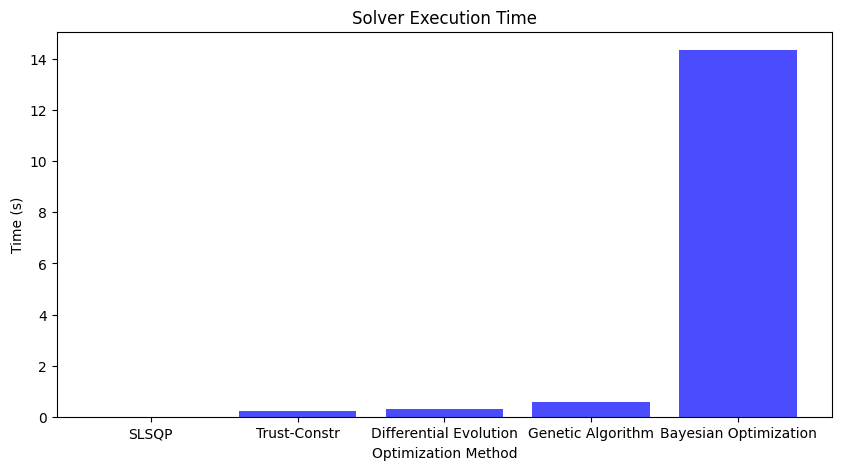

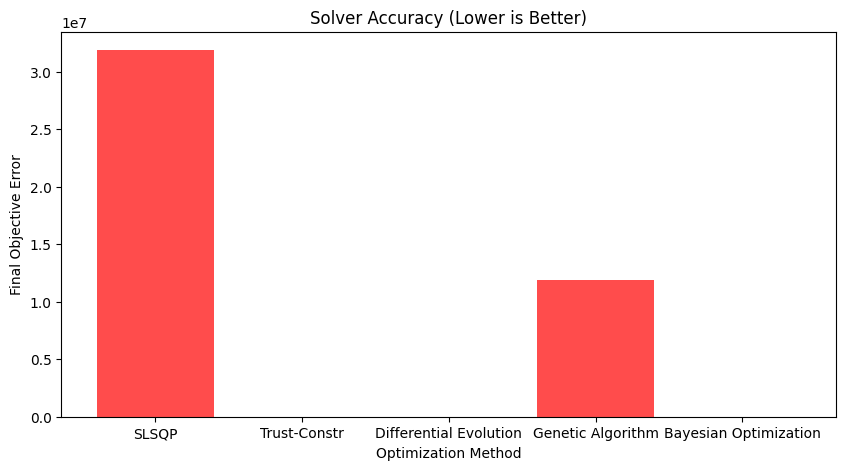

Solver: SLSQP
  Optimal stage fractions: [0.2 0.3]
  Engine-provided Delta-V (per stage): [3726.57148121 3128.10660373]
  Total engine Delta-V: 6854.6780849383285
  Net Delta-V after losses: 4854.6780849383285
-----
Solver: Trust-Constr
  Optimal stage fractions: [0.05044307 0.0531823 ]
  Engine-provided Delta-V (per stage): [6095.12907312 6404.87094583]
  Total engine Delta-V: 12500.000018950963
  Net Delta-V after losses: 10500.000018950963
-----
Solver: Differential Evolution
  Optimal stage fractions: [0.05309715 0.05026275]
  Engine-provided Delta-V (per stage): [6029.43483197 6470.56516803]
  Total engine Delta-V: 12500.0
  Net Delta-V after losses: 10500.0
-----
Solver: Genetic Algorithm
  Optimal stage fractions: 0.15
  Engine-provided Delta-V (per stage): [4317.40714375 4732.64259354]
  Total engine Delta-V: 9050.049737294317
  Net Delta-V after losses: 7050.049737294317
-----
Solver: Bayesian Optimization
  Optimal stage fractions: [0.05, 0.05]
  Engine-provided Delta-V (per 

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.optimize import minimize, differential_evolution
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize as pymoo_minimize
from pymoo.core.problem import Problem
from skopt import gp_minimize

# Constants
G0 = 9.81  # Gravitational acceleration (m/s²)
ISP = np.array([282, 348])  # Specific impulse for Falcon 9 stages
EPSILON = np.array([0.03, 0.07])  # Structural mass fractions
PAYLOAD_FRACTION = 0.03  # Payload fraction (3% of total mass)
TOTAL_DELTA_V = 10500  # Required net mission ΔV (m/s)

# Delta-V losses (m/s)
GRAVITY_LOSS = 1500   # Loss due to gravity (m/s)
DRAG_LOSS = 500       # Loss due to aerodynamic drag (m/s)

# Function to compute ΔV for each stage (engine-provided)
def delta_v_function(stage_fractions, isp):
    """
    Calculate the engine-provided delta-v for each stage.
    
    :param stage_fractions: Array of mass fractions for each stage.
    :param isp: Array of specific impulses for each stage.
    :return: Array of delta-v contributions from each stage.
    """
    return G0 * isp * np.log(1 / (EPSILON + PAYLOAD_FRACTION + stage_fractions))

def objective(stage_fractions, total_delta_v, isp):
    required_engine_delta_v = total_delta_v + GRAVITY_LOSS + DRAG_LOSS
    produced_delta_v = np.sum(delta_v_function(stage_fractions, isp))
    return (produced_delta_v - required_engine_delta_v)**2  # Changed to squared error

# Number of stages
NUM_STAGES = len(ISP)

# Bounds for optimization
BOUNDS = [(0.05, 0.85) for _ in range(NUM_STAGES)]
X0 = np.array([0.2, 0.3])  # Initial guess

def benchmark_solver(method_name, solver_func):
    """
    Benchmark an optimization solver by timing its execution and measuring its accuracy.
    
    :param method_name: Name of the method for display purposes.
    :param solver_func: Function that returns the solver result.
    :return: Tuple with method name, execution time, final error, and optimized fractions.
    """
    start_time = time.time()
    result = solver_func()
    
    # Extract optimized values
    if hasattr(result, "x"):
        optimized_fractions = result.x
        final_error = result.fun
    elif hasattr(result, "X"):  # For pymoo result
        optimized_fractions = result.X[0]  # Take first solution for clarity
        final_error = objective(optimized_fractions, TOTAL_DELTA_V, ISP)
    else:
        optimized_fractions = result
        final_error = objective(optimized_fractions, TOTAL_DELTA_V, ISP)

    elapsed_time = time.time() - start_time
    
    # Compute and report the error
    produced = np.sum(delta_v_function(optimized_fractions, ISP))
    error = produced - (TOTAL_DELTA_V + GRAVITY_LOSS + DRAG_LOSS)
    print(f"{method_name} -> Time: {elapsed_time:.4f}s | Final Error: {final_error:.2f} | Physical Mismatch: {error:.2f} | Solution: {optimized_fractions}")
    return method_name, elapsed_time, final_error, optimized_fractions

# Solver definitions

def solver_slsqp():
    return minimize(objective, X0, args=(TOTAL_DELTA_V, ISP), bounds=BOUNDS, method='SLSQP')

def solver_trust_constr():
    return minimize(objective, X0, args=(TOTAL_DELTA_V, ISP), bounds=BOUNDS, method='trust-constr')

def solver_differential_evolution():
    return differential_evolution(objective, BOUNDS, args=(TOTAL_DELTA_V, ISP))

class StageOptimizationProblem(Problem):
    def __init__(self):
        super().__init__(n_var=NUM_STAGES, n_obj=1, n_constr=0, xl=0.15, xu=0.85)
        
    def _evaluate(self, x, out, *args, **kwargs):
        # Compute engine-provided delta-v for each candidate,
        # then include losses in the target.
        required_engine_delta_v = TOTAL_DELTA_V + GRAVITY_LOSS + DRAG_LOSS
        produced = np.sum(delta_v_function(x, ISP), axis=1)
        f = (produced - required_engine_delta_v)**2
        out["F"] = f[:, np.newaxis]  # Ensure shape is (N, 1)

def solver_genetic_algorithm():
    problem = StageOptimizationProblem()
    algorithm = GA(pop_size=100)
    res = pymoo_minimize(problem, algorithm, seed=1, verbose=False)
    return res.X[0]  # Ensure that this returns a full vector of length NUM_STAGES

def solver_bayesian():
    return gp_minimize(lambda x: objective(x, TOTAL_DELTA_V, ISP), BOUNDS, n_calls=50, random_state=0)

# Run and benchmark all solvers
SOLVERS = [
    ("SLSQP", solver_slsqp),
    ("Trust-Constr", solver_trust_constr),
    ("Differential Evolution", solver_differential_evolution),
    ("Genetic Algorithm", solver_genetic_algorithm),
    ("Bayesian Optimization", solver_bayesian),
]

results = [benchmark_solver(name, func) for name, func in SOLVERS]

# Visualization of execution time and error
solver_names, times, errors, solutions = zip(*results)

plt.figure(figsize=(10, 5))
plt.bar(solver_names, times, color='blue', alpha=0.7)
plt.xlabel("Optimization Method")
plt.ylabel("Time (s)")
plt.title("Solver Execution Time")
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(solver_names, errors, color='red', alpha=0.7)
plt.xlabel("Optimization Method")
plt.ylabel("Final Objective Error")
plt.title("Solver Accuracy (Lower is Better)")
plt.show()

# Optional: Print detailed delta-v breakdown for each solver result
for name, _, _, optimal in results:
    if optimal is not None:
        dv_per_stage = delta_v_function(optimal, ISP)
        total_engine_dv = np.sum(dv_per_stage)
        net_dv = total_engine_dv - (GRAVITY_LOSS + DRAG_LOSS)
        error_physical = total_engine_dv - (TOTAL_DELTA_V + GRAVITY_LOSS + DRAG_LOSS)
    else:
        dv_per_stage = None
        total_engine_dv = None
        net_dv = None
        error_physical = None

    print(f"Solver: {name}")
    print("  Optimal stage fractions:", optimal)
    print("  Engine-provided Delta-V (per stage):", dv_per_stage)
    print("  Total engine Delta-V:", total_engine_dv)
    print("  Net Delta-V after losses:", net_dv)
    print("  Physical Mismatch:", error_physical)
    print("-----")

In [159]:
# %% [code]
# Dictionary to store results from each solver
results = {}

for solver in solvers:
    start_time = time.time()
    try:
        p_opt = Nstage(vf, beta, epsilon, alpha, solver=solver)
        elapsed_time = time.time() - start_time
        if p_opt is not None:
            # Compute the per-stage delta-V contributions:
            # Each stage: ΔV_k = Isp_k * g0 * ln((epsilon_k + alpha_k*(1-epsilon_k)*p_opt) / epsilon_k)
            ratio = (epsilon + alpha * (1 - epsilon) * p_opt) / epsilon
            deltaV_stages = Isp * g0 * np.log(np.maximum(ratio, 1e-9))
            # Sum the contributions to get total delta-V
            total_deltaV = np.sum(deltaV_stages)
        else:
            deltaV_stages = None
            total_deltaV = None
        results[solver] = {
            'p_opt': p_opt,
            'deltaV': deltaV_stages,
            'total_deltaV': total_deltaV,
            'time': elapsed_time
        }
    except ValueError as e:
        results[solver] = {
            'p_opt': None,
            'deltaV': None,
            'total_deltaV': None,
            'time': None
        }
        print(f"Solver {solver} failed: {e}")

# Print the results in a clear format
for solver in solvers:
    res = results[solver]
    print(f"Solver: {solver}")
    print(f"  Optimal p: {res['p_opt']}")
    if res['deltaV'] is not None:
        print(f"  Delta-V (per stage): {res['deltaV']}")
        print(f"  Total Delta-V: {res['total_deltaV']} m/s")
    else:
        print("  Delta-V (per stage): None")
        print("  Total Delta-V: None")
    if res['time'] is not None:
        print(f"  Computation time: {res['time']:.4f} sec\n")
    else:
        print("  Computation time: N/A\n")


Solver: newton
  Optimal p: None
  Delta-V (per stage): None
  Total Delta-V: None
  Computation time: 0.0030 sec

Solver: bisection
  Optimal p: None
  Delta-V (per stage): None
  Total Delta-V: None
  Computation time: 0.0042 sec

Solver: secant
  Optimal p: None
  Delta-V (per stage): None
  Total Delta-V: None
  Computation time: 0.0000 sec

Solver: scipy
  Optimal p: None
  Delta-V (per stage): None
  Total Delta-V: None
  Computation time: 0.0041 sec

Solver: genetic
  Optimal p: 1.2227937611170039
  Delta-V (per stage): [ 8309.09931397 11650.54596218]
  Total Delta-V: 19959.645276147778 m/s
  Computation time: 0.1427 sec

Solver: fixed_point
  Optimal p: None
  Delta-V (per stage): None
  Total Delta-V: None
  Computation time: 0.0000 sec

Solver: false_position
  Optimal p: None
  Delta-V (per stage): None
  Total Delta-V: None
  Computation time: 0.0000 sec

Solver: nelder_mead
  Optimal p: None
  Delta-V (per stage): None
  Total Delta-V: None
  Computation time: 0.0000 sec



In [160]:
# %% [code]
# Prepare data for plotting
solver_names = []
stage1_dv = []
stage2_dv = []
stage3_dv = []
comp_times = []

for solver in solvers:
    solver_names.append(solver.capitalize())
    res = results[solver]
    if res['deltaV'] is not None:
        # Each deltaV is an array for the three stages.
        stage1_dv.append(res['deltaV'][0])
        stage2_dv.append(res['deltaV'][1])
        stage3_dv.append(res['deltaV'][2])
        comp_times.append(res['time'])
    else:
        stage1_dv.append(0)
        stage2_dv.append(0)
        stage3_dv.append(0)
        comp_times.append(0)

# Set up the bar width and positions
x = np.arange(len(solver_names))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, stage1_dv, width, label='Stage 1')
rects2 = ax.bar(x, stage2_dv, width, label='Stage 2')
rects3 = ax.bar(x + width, stage3_dv, width, label='Stage 3')

ax.set_ylabel('Delta-V (m/s)')
ax.set_title('Delta-V Contributions per Stage by Solver')
ax.set_xticks(x)
ax.set_xticklabels(solver_names)
ax.legend()

# Optionally annotate computation times above each group
for i, t in enumerate(comp_times):
    ax.text(x[i], max(stage1_dv[i], stage2_dv[i], stage3_dv[i]) + 50,
            f"{t:.3f}s", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


IndexError: index 2 is out of bounds for axis 0 with size 2